# Imports y configuraciones básicas

Algunos imports que se utilizarán en el resto del notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from bwb.distributions import *
from bwb.utils import plot_list_of_draws, plot_histogram_from_points

import pandas as pd
import itertools

In [2]:
# import logging
# log = logging.getLogger("bwb.distributions")
# log.setLevel(logging.DEBUG)

Importamos los datos del archivo de Google Cloud

In [3]:
data = np.load(r"..\data\face.npy")
data.shape

(161666, 784)

Haremos dos listas de caritas: una sin modificación, y otra con modificación.

In [4]:
%%time

CEIL = 50
n_faces = len(data)
rng = np.random.default_rng(42)


# Builder para hacer las caritas
dist_draw_builder = DistributionDrawBuilder(
    seed=rng,
)

# Conjunto de caritas originales (distintos soportes)
faces_original = list()
for i in range(n_faces):
    arr = 255 - data[i, :].reshape(28, 28)
    dd_arr = dist_draw_builder.create_fromarray(arr)
    faces_original.append(dd_arr)
    
    
# Conjuntos de caritas con soporte no-nulo
dist_draw_builder.set_ceil(CEIL)
    
faces_modified = list()
for i in range(n_faces):
    arr = 255 - data[i, :].reshape(28, 28)
    dd_arr = dist_draw_builder.create_fromarray(arr)
    faces_modified.append(dd_arr)
    
len(faces_original), len(faces_modified)

CPU times: total: 10.7 s
Wall time: 10.8 s


(161666, 161666)

`faces_original` son las caritas sin modificar el soporte, mientras que `faces_modified` es con los que tiene soporte no-nulo.

Obtendremos la data $D = \{x_i\}_{i=1}^{n}\subseteq\mathcal{X}^n$, y probaremos los métodos para distintos valores de $n$.

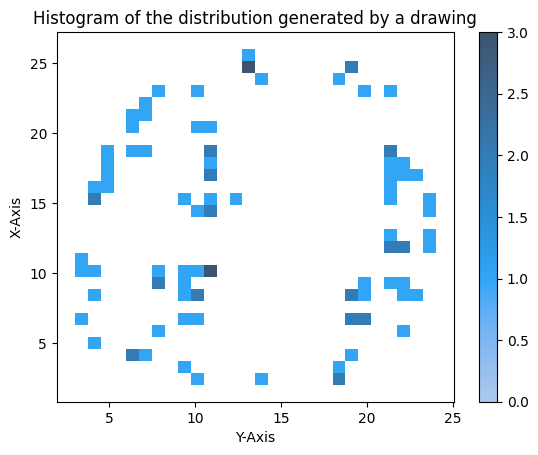

In [5]:
first_face = DistributionDraw.fromarray(
    255 - data[0, :].reshape(28, 28),
    seed=42
)

x = first_face.rvs(size=100)

plot_histogram_from_points(x, histplot_kwargs=dict(bins=28))
plt.show()

In [6]:
# Tiempo de cálculo del caché

De forma implícita, las clases `MetropolisPosteriorPiN` y `GibbsPosteriorPiN` hacen un pre-procesamiento para calcular a modo de caché todas las verosimilitudes. En este notebook se calcularán los tiempos de iniciación para calcular este caché, tanto para cada uno de los diferentes métodos como para la lista de conjunto de caritas originales y modificadas.

In [7]:
%%time
# %%script false --no-raise-error


def fmt_avg_stdev(avg, stdev):
    return f"{avg:.4f} ± {stdev:.4f}"


resume_df = pd.DataFrame()

n_list = [5, 25, 50, 100]

for n in n_list:
    kwargs = dict(data=x[:n], models=faces_original, seed=rng)
    
    print(f"Metropolis Original: {n = }")
    result = %timeit -o MetropolisPosteriorPiN(**kwargs)
    resume_df.loc[n, "Time M. original [seg]"] = fmt_avg_stdev(result.average, result.stdev)
    
    print(f"Gibbs Original: {n = }")
    result = %timeit -o GibbsPosteriorPiN(**kwargs)
    resume_df.loc[n, "Time G. original [seg]"] = fmt_avg_stdev(result.average, result.stdev)
    
    kwargs["models"] = faces_modified
    
    print(f"Metropolis Modified: {n = }")
    result = %timeit -o MetropolisPosteriorPiN(**kwargs)
    resume_df.loc[n, "Time M. modified [seg]"] = fmt_avg_stdev(result.average, result.stdev)
    
    print(f"Gibbs Modified: {n = }")
    result = %timeit -o GibbsPosteriorPiN(**kwargs)
    resume_df.loc[n, "Time G. modified [seg]"] = fmt_avg_stdev(result.average, result.stdev)
    
print(resume_df.to_html())
print("="*20)
print(resume_df.to_latex())

Metropolis Original: n = 5
394 ms ± 29.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Gibbs Original: n = 5
364 ms ± 5.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Metropolis Modified: n = 5
880 ms ± 215 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Gibbs Modified: n = 5
737 ms ± 26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Metropolis Original: n = 25
The slowest run took 5.26 times longer than the fastest. This could mean that an intermediate result is being cached.
1.42 s ± 870 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Gibbs Original: n = 25
517 ms ± 29.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Metropolis Modified: n = 25
3.93 s ± 367 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Gibbs Modified: n = 25
3.12 s ± 351 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Metropolis Original: n = 50
512 ms ± 75.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Gibbs Original: n = 50
395 ms ± 16.8 ms per loop

C:\Users\asoln\PycharmProjects\PersonalProjects\Bayesian-Learning-with-Wasserstein-Barycenters\bwb\distributions.py:267: UserWarning: The likelihood support has only one element.
  warnings.warn("The likelihood support has only one element.")


403 ms ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Gibbs Original: n = 100


C:\Users\asoln\PycharmProjects\PersonalProjects\Bayesian-Learning-with-Wasserstein-Barycenters\bwb\distributions.py:267: UserWarning: The likelihood support has only one element.
  warnings.warn("The likelihood support has only one element.")


536 ms ± 57.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Metropolis Modified: n = 100
10.9 s ± 435 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Gibbs Modified: n = 100
11.1 s ± 704 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Time M. original [seg]</th>
      <th>Time G. original [seg]</th>
      <th>Time M. modified [seg]</th>
      <th>Time G. modified [seg]</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>0.3935 ± 0.0293</td>
      <td>0.3643 ± 0.0055</td>
      <td>0.8802 ± 0.2153</td>
      <td>0.7374 ± 0.0260</td>
    </tr>
    <tr>
      <th>25</th>
      <td>1.4218 ± 0.8703</td>
      <td>0.5172 ± 0.0295</td>
      <td>3.9343 ± 0.3675</td>
      <td>3.1201 ± 0.3513</td>
    </tr>
    <tr>
      <th>50</th>
      <td>0.5124 ± 0.0753</td>
      <td>0.3953 ± 0.0168</td>
      <td>5.9938 ± 0.6516</td>
      <td>5.4910 ± 0.1

<timed exec>:35: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Time M. original [seg]</th>
      <th>Time G. original [seg]</th>
      <th>Time M. modified [seg]</th>
      <th>Time G. modified [seg]</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>0.3336 ± 0.0313</td>
      <td>0.3104 ± 0.0273</td>
      <td>0.6644 ± 0.0747</td>
      <td>0.5780 ± 0.0249</td>
    </tr>
    <tr>
      <th>25</th>
      <td>0.3312 ± 0.0139</td>
      <td>0.3304 ± 0.0190</td>
      <td>2.4187 ± 0.0504</td>
      <td>2.8125 ± 0.3133</td>
    </tr>
    <tr>
      <th>50</th>
      <td>0.4299 ± 0.0807</td>
      <td>0.4798 ± 0.1267</td>
      <td>4.8916 ± 0.1065</td>
      <td>4.8937 ± 0.2163</td>
    </tr>
    <tr>
      <th>100</th>
      <td>0.3456 ± 0.0264</td>
      <td>0.3423 ± 0.0157</td>
      <td>9.1654 ± 0.0452</td>
      <td>9.4425 ± 0.3818</td>
    </tr>
  </tbody>
</table>

Ahora queremos ver el número de muestras que se samplean de las distribuciones y el tiempo que se demora, como también el tiempo promedio que se demora por cada iteración y por cada método

In [8]:
# Tables
m_num_samples_original = pd.DataFrame()
m_total_time_original = pd.DataFrame()

g_num_samples_original = pd.DataFrame()
g_total_time_original = pd.DataFrame()

m_num_samples_modified = pd.DataFrame()
m_total_time_modified = pd.DataFrame()

g_num_samples_modified = pd.DataFrame()
g_total_time_modified = pd.DataFrame()

In [9]:
%%time
# %%script false --no-raise-error

# n-k lists
n_list = [5, 25, 50, 75]
k_list = [1, 50, 100, 500, 1000, 2500]


# Iterate over n/k
for n, k in itertools.product(n_list, k_list):
    kwargs = dict(data=x[:n], models=faces_original, seed=rng)
    
    
    print(f"Metropolis original {n = }, {k = }")
    mcmc = AlternativeMetropolisPosteriorPiN(**kwargs)
    
    # Do the experiment
    result = %timeit -n1 -o -r1 mcmc.rvs(size=k)
    print(f"{len(mcmc.counter) = }")
    print(f"{result.average = }")
    m_num_samples_original.loc[n, k] = len(mcmc.counter)
    m_total_time_original.loc[n, k] = f"{result.average:.4f}"
    
    
    print(f"Gibbs original {n = }, {k = }")
    mcmc = AlternativeGibbsPosteriorPiN(**kwargs)
    
    # Do the experiment
    result = %timeit -n1 -o -r1 mcmc.rvs(size=k)
    print(f"{len(mcmc.counter) = }")
    print(f"{result.average = }")
    g_num_samples_original.loc[n, k] = len(mcmc.counter)
    g_total_time_original.loc[n, k] = f"{result.average:.4f}"
    
    
    
    kwargs["models"] = faces_modified
    
    print(f"Metropolis modified {n = }, {k = }")
    mcmc = AlternativeMetropolisPosteriorPiN(**kwargs)
    
    # Do the experiment
    result = %timeit -n1 -o -r1 mcmc.rvs(size=k)
    print(f"{len(mcmc.counter) = }")
    print(f"{result.average = }")
    m_num_samples_modified.loc[n, k] = len(mcmc.counter)
    m_total_time_modified.loc[n, k] = f"{result.average:.4f}"
    
    
    print(f"Gibbs modified {n = }, {k = }")
    mcmc = AlternativeGibbsPosteriorPiN(**kwargs)
    
    # Do the experiment
    result = %timeit -n1 -o -r1 mcmc.rvs(size=k)
    print(f"{len(mcmc.counter) = }")
    print(f"{result.average = }")
    g_num_samples_modified.loc[n, k] = len(mcmc.counter)
    g_total_time_modified.loc[n, k] = f"{result.average:.4f}"
    
#     break

Metropolis original n = 5, k = 1
4.75 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 1
result.average = 0.004745300000649877
Gibbs original n = 5, k = 1
1.66 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 1
result.average = 0.0016604999982519075
Metropolis modified n = 5, k = 1
22.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 1
result.average = 0.02228839999588672
Gibbs modified n = 5, k = 1
17 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 1
result.average = 0.01700419999542646
Metropolis original n = 5, k = 50
58.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 8
result.average = 0.05869259999599308
Gibbs original n = 5, k = 50
68.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 49
result.average = 0.06880969999474473
Metropolis modified n = 5, k = 50
907 ms ± 0 ns per loop (mean ± std.

2.76 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 1
result.average = 0.0027572999970288947
Metropolis modified n = 50, k = 50
1.11 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 6
result.average = 1.1069519999873592
Gibbs modified n = 50, k = 50
865 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 2
result.average = 0.8653665000019828
Metropolis original n = 50, k = 100
6.65 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 2
result.average = 0.006654500000877306
Gibbs original n = 50, k = 100
6.63 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 1
result.average = 0.006626000002142973
Metropolis modified n = 50, k = 100
1.81 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 5
result.average = 1.8058601999946404
Gibbs modified n = 50, k = 100
1.85 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop e

C:\Users\asoln\PycharmProjects\PersonalProjects\Bayesian-Learning-with-Wasserstein-Barycenters\bwb\distributions.py:267: UserWarning: The likelihood support has only one element.
  warnings.warn("The likelihood support has only one element.")


76.2 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 1
result.average = 7.619999814778566e-05
Gibbs original n = 75, k = 1


C:\Users\asoln\PycharmProjects\PersonalProjects\Bayesian-Learning-with-Wasserstein-Barycenters\bwb\distributions.py:267: UserWarning: The likelihood support has only one element.
  warnings.warn("The likelihood support has only one element.")


37.9 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 1
result.average = 3.789999755099416e-05
Metropolis modified n = 75, k = 1
17.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 1
result.average = 0.017288600007304922
Gibbs modified n = 75, k = 1
17.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 1
result.average = 0.017658099997788668
Metropolis original n = 75, k = 50


C:\Users\asoln\PycharmProjects\PersonalProjects\Bayesian-Learning-with-Wasserstein-Barycenters\bwb\distributions.py:267: UserWarning: The likelihood support has only one element.
  warnings.warn("The likelihood support has only one element.")


468 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 1
result.average = 0.00046799999836366624
Gibbs original n = 75, k = 50
451 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 1
result.average = 0.000450999999884516
Metropolis modified n = 75, k = 50
914 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 4
result.average = 0.9137151000031736
Gibbs modified n = 75, k = 50
1.23 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 2
result.average = 1.2283792000089306
Metropolis original n = 75, k = 100
957 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 1
result.average = 0.0009572000126354396
Gibbs original n = 75, k = 100
5.07 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
len(mcmc.counter) = 1
result.average = 0.005072999992989935
Metropolis modified n = 75, k = 100
1.92 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop 

In [10]:
df = m_num_samples_original
print(df.to_html())
print("="*20)
print(df.to_latex())
df

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>1.0</td>
      <td>8.0</td>
      <td>27.0</td>
      <td>79.0</td>
      <td>190.0</td>
      <td>427.0</td>
    </tr>
    <tr>
      <th>25</th>
      <td>1.0</td>
      <td>10.0</td>
      <td>2.0</td>
      <td>6.0</td>
      <td>12.0</td>
      <td>6.0</td>
    </tr>
    <tr>
      <th>50</th>
      <td>1.0</td>
      <td>2.0</td>
      <td>2.0</td>
      <td>2.0</td>
      <td>2.0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <th>75</th>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
    </tr>
  </tbody>
</table>
\begin{tabular}{lrrrrrr}
\toprule
{} &  1    &  50   &  100  &  500  &   1000 &   2500 \\
\midrule
5  &   1.0 &   8.0 &  27.0 

C:\Users\asoln\AppData\Local\Temp\ipykernel_15944\2720494417.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


,1,50,100,500,1000,2500
5,1.0,8.0,27.0,79.0,190.0,427.0
25,1.0,10.0,2.0,6.0,12.0,6.0
50,1.0,2.0,2.0,2.0,2.0,1.0
75,1.0,1.0,1.0,1.0,1.0,1.0


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>1.0</td>
      <td>12.0</td>
      <td>20.0</td>
      <td>101.0</td>
      <td>195.0</td>
      <td>441.0</td>
    </tr>
    <tr>
      <th>25</th>
      <td>1.0</td>
      <td>3.0</td>
      <td>6.0</td>
      <td>3.0</td>
      <td>5.0</td>
      <td>16.0</td>
    </tr>
    <tr>
      <th>50</th>
      <td>1.0</td>
      <td>2.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <th>75</th>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
    </tr>
  </tbody>
</table>

In [11]:
df = m_total_time_original
print(df.to_html())
print("="*20)
print(df.to_latex())
df

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>0.0047</td>
      <td>0.0587</td>
      <td>0.1207</td>
      <td>0.6099</td>
      <td>1.2530</td>
      <td>3.0740</td>
    </tr>
    <tr>
      <th>25</th>
      <td>0.0020</td>
      <td>0.0066</td>
      <td>0.0124</td>
      <td>0.0435</td>
      <td>0.0817</td>
      <td>0.1964</td>
    </tr>
    <tr>
      <th>50</th>
      <td>0.0006</td>
      <td>0.0037</td>
      <td>0.0067</td>
      <td>0.0352</td>
      <td>0.0717</td>
      <td>0.1650</td>
    </tr>
    <tr>
      <th>75</th>
      <td>0.0001</td>
      <td>0.0005</td>
      <td>0.0010</td>
      <td>0.0040</td>
      <td>0.0087</td>
      <td>0.0229</td>
    </tr>
  </tbody>
</table>
\begin{tabular}{lllllll}
\toprule
{} &    1    &    50   &    

C:\Users\asoln\AppData\Local\Temp\ipykernel_15944\464901164.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


,1,50,100,500,1000,2500
5,0.0047,0.0587,0.1207,0.6099,1.2530,3.0740
25,0.0020,0.0066,0.0124,0.0435,0.0817,0.1964
50,0.0006,0.0037,0.0067,0.0352,0.0717,0.1650
75,0.0001,0.0005,0.0010,0.0040,0.0087,0.0229


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>0.0014</td>
      <td>0.0511</td>
      <td>0.1043</td>
      <td>0.6535</td>
      <td>1.1080</td>
      <td>2.9345</td>
    </tr>
    <tr>
      <th>25</th>
      <td>0.0024</td>
      <td>0.0032</td>
      <td>0.0116</td>
      <td>0.0331</td>
      <td>0.0811</td>
      <td>0.1687</td>
    </tr>
    <tr>
      <th>50</th>
      <td>0.0002</td>
      <td>0.0043</td>
      <td>0.0136</td>
      <td>0.0345</td>
      <td>0.0570</td>
      <td>0.1401</td>
    </tr>
    <tr>
      <th>75</th>
      <td>0.0001</td>
      <td>0.0007</td>
      <td>0.0008</td>
      <td>0.0037</td>
      <td>0.0071</td>
      <td>0.0177</td>
    </tr>
  </tbody>
</table>

In [12]:
df = g_num_samples_original
print(df.to_html())
print("="*20)
print(df.to_latex())
df

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>1.0</td>
      <td>49.0</td>
      <td>94.0</td>
      <td>408.0</td>
      <td>725.0</td>
      <td>1404.0</td>
    </tr>
    <tr>
      <th>25</th>
      <td>1.0</td>
      <td>2.0</td>
      <td>5.0</td>
      <td>5.0</td>
      <td>9.0</td>
      <td>11.0</td>
    </tr>
    <tr>
      <th>50</th>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>2.0</td>
      <td>1.0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <th>75</th>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
    </tr>
  </tbody>
</table>
\begin{tabular}{lrrrrrr}
\toprule
{} &  1    &  50   &  100  &   500  &   1000 &    2500 \\
\midrule
5  &   1.0 &  49.0 &  9

C:\Users\asoln\AppData\Local\Temp\ipykernel_15944\2923686.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


,1,50,100,500,1000,2500
5,1.0,49.0,94.0,408.0,725.0,1404.0
25,1.0,2.0,5.0,5.0,9.0,11.0
50,1.0,1.0,1.0,2.0,1.0,1.0
75,1.0,1.0,1.0,1.0,1.0,1.0


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>1.0</td>
      <td>49.0</td>
      <td>97.0</td>
      <td>403.0</td>
      <td>738.0</td>
      <td>1405.0</td>
    </tr>
    <tr>
      <th>25</th>
      <td>1.0</td>
      <td>5.0</td>
      <td>4.0</td>
      <td>5.0</td>
      <td>13.0</td>
      <td>15.0</td>
    </tr>
    <tr>
      <th>50</th>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <th>75</th>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
      <td>1.0</td>
    </tr>
  </tbody>
</table>

In [13]:
df = g_total_time_original
print(df.to_html())
print("="*20)
print(df.to_latex())
df

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>0.0017</td>
      <td>0.0688</td>
      <td>0.1269</td>
      <td>0.6166</td>
      <td>1.2336</td>
      <td>3.0303</td>
    </tr>
    <tr>
      <th>25</th>
      <td>0.0003</td>
      <td>0.0034</td>
      <td>0.0073</td>
      <td>0.0322</td>
      <td>0.0617</td>
      <td>0.1521</td>
    </tr>
    <tr>
      <th>50</th>
      <td>0.0001</td>
      <td>0.0028</td>
      <td>0.0066</td>
      <td>0.0262</td>
      <td>0.0548</td>
      <td>0.1315</td>
    </tr>
    <tr>
      <th>75</th>
      <td>0.0000</td>
      <td>0.0005</td>
      <td>0.0051</td>
      <td>0.0041</td>
      <td>0.0090</td>
      <td>0.0208</td>
    </tr>
  </tbody>
</table>
\begin{tabular}{lllllll}
\toprule
{} &    1    &    50   &    

C:\Users\asoln\AppData\Local\Temp\ipykernel_15944\3575265899.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


,1,50,100,500,1000,2500
5,0.0017,0.0688,0.1269,0.6166,1.2336,3.0303
25,0.0003,0.0034,0.0073,0.0322,0.0617,0.1521
50,0.0001,0.0028,0.0066,0.0262,0.0548,0.1315
75,0.0000,0.0005,0.0051,0.0041,0.0090,0.0208


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>0.0012</td>
      <td>0.0610</td>
      <td>0.1108</td>
      <td>0.6387</td>
      <td>1.0874</td>
      <td>3.2232</td>
    </tr>
    <tr>
      <th>25</th>
      <td>0.0006</td>
      <td>0.0029</td>
      <td>0.0071</td>
      <td>0.0332</td>
      <td>0.0568</td>
      <td>0.1391</td>
    </tr>
    <tr>
      <th>50</th>
      <td>0.0002</td>
      <td>0.0043</td>
      <td>0.0054</td>
      <td>0.0243</td>
      <td>0.0459</td>
      <td>0.1150</td>
    </tr>
    <tr>
      <th>75</th>
      <td>0.0000</td>
      <td>0.0004</td>
      <td>0.0007</td>
      <td>0.0045</td>
      <td>0.0075</td>
      <td>0.0179</td>
    </tr>
  </tbody>
</table>

In [14]:
df = m_num_samples_modified
print(df.to_html())
print("="*20)
print(df.to_latex())
df

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>1.0</td>
      <td>12.0</td>
      <td>24.0</td>
      <td>134.0</td>
      <td>280.0</td>
      <td>731.0</td>
    </tr>
    <tr>
      <th>25</th>
      <td>1.0</td>
      <td>4.0</td>
      <td>15.0</td>
      <td>23.0</td>
      <td>32.0</td>
      <td>46.0</td>
    </tr>
    <tr>
      <th>50</th>
      <td>1.0</td>
      <td>6.0</td>
      <td>5.0</td>
      <td>11.0</td>
      <td>12.0</td>
      <td>9.0</td>
    </tr>
    <tr>
      <th>75</th>
      <td>1.0</td>
      <td>4.0</td>
      <td>6.0</td>
      <td>9.0</td>
      <td>7.0</td>
      <td>17.0</td>
    </tr>
  </tbody>
</table>
\begin{tabular}{lrrrrrr}
\toprule
{} &  1    &  50   &  100  &   500  &   1000 &   2500 \\
\midrule
5  &   1.0 &  12.0 

C:\Users\asoln\AppData\Local\Temp\ipykernel_15944\802287782.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


,1,50,100,500,1000,2500
5,1.0,12.0,24.0,134.0,280.0,731.0
25,1.0,4.0,15.0,23.0,32.0,46.0
50,1.0,6.0,5.0,11.0,12.0,9.0
75,1.0,4.0,6.0,9.0,7.0,17.0


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>1.0</td>
      <td>11.0</td>
      <td>13.0</td>
      <td>87.0</td>
      <td>203.0</td>
      <td>752.0</td>
    </tr>
    <tr>
      <th>25</th>
      <td>1.0</td>
      <td>7.0</td>
      <td>9.0</td>
      <td>1.0</td>
      <td>17.0</td>
      <td>15.0</td>
    </tr>
    <tr>
      <th>50</th>
      <td>1.0</td>
      <td>5.0</td>
      <td>8.0</td>
      <td>8.0</td>
      <td>12.0</td>
      <td>17.0</td>
    </tr>
    <tr>
      <th>75</th>
      <td>1.0</td>
      <td>8.0</td>
      <td>9.0</td>
      <td>14.0</td>
      <td>7.0</td>
      <td>9.0</td>
    </tr>
  </tbody>
</table>

In [15]:
df = m_total_time_modified
print(df.to_html())
print("="*20)
print(df.to_latex())
df

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>0.0223</td>
      <td>0.9072</td>
      <td>1.8151</td>
      <td>9.1276</td>
      <td>18.9415</td>
      <td>45.4199</td>
    </tr>
    <tr>
      <th>25</th>
      <td>0.0176</td>
      <td>0.9469</td>
      <td>1.9008</td>
      <td>11.1570</td>
      <td>18.2797</td>
      <td>45.7812</td>
    </tr>
    <tr>
      <th>50</th>
      <td>0.0184</td>
      <td>1.1070</td>
      <td>1.8059</td>
      <td>9.0731</td>
      <td>18.0269</td>
      <td>45.0218</td>
    </tr>
    <tr>
      <th>75</th>
      <td>0.0173</td>
      <td>0.9137</td>
      <td>1.9195</td>
      <td>9.0181</td>
      <td>19.3441</td>
      <td>45.4159</td>
    </tr>
  </tbody>
</table>
\begin{tabular}{lllllll}
\toprule
{} &    1    &    5

C:\Users\asoln\AppData\Local\Temp\ipykernel_15944\1655671937.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


,1,50,100,500,1000,2500
5,0.0223,0.9072,1.8151,9.1276,18.9415,45.4199
25,0.0176,0.9469,1.9008,11.1570,18.2797,45.7812
50,0.0184,1.1070,1.8059,9.0731,18.0269,45.0218
75,0.0173,0.9137,1.9195,9.0181,19.3441,45.4159


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>0.0162</td>
      <td>0.8749</td>
      <td>1.6367</td>
      <td>8.2336</td>
      <td>17.0771</td>
      <td>41.5876</td>
    </tr>
    <tr>
      <th>25</th>
      <td>0.0155</td>
      <td>0.9267</td>
      <td>1.6738</td>
      <td>8.7581</td>
      <td>16.6361</td>
      <td>41.8724</td>
    </tr>
    <tr>
      <th>50</th>
      <td>0.0155</td>
      <td>0.8342</td>
      <td>2.3497</td>
      <td>8.8038</td>
      <td>18.3098</td>
      <td>41.6662</td>
    </tr>
    <tr>
      <th>75</th>
      <td>0.0151</td>
      <td>0.8028</td>
      <td>1.6917</td>
      <td>8.4317</td>
      <td>16.3477</td>
      <td>44.5841</td>
    </tr>
  </tbody>
</table>

In [16]:
df = g_num_samples_modified
print(df.to_html())
print("="*20)
print(df.to_latex())
df

C:\Users\asoln\AppData\Local\Temp\ipykernel_15944\1233317404.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>1.0</td>
      <td>50.0</td>
      <td>100.0</td>
      <td>497.0</td>
      <td>971.0</td>
      <td>2356.0</td>
    </tr>
    <tr>
      <th>25</th>
      <td>1.0</td>
      <td>33.0</td>
      <td>62.0</td>
      <td>211.0</td>
      <td>387.0</td>
      <td>701.0</td>
    </tr>
    <tr>
      <th>50</th>
      <td>1.0</td>
      <td>2.0</td>
      <td>2.0</td>
      <td>3.0</td>
      <td>2.0</td>
      <td>4.0</td>
    </tr>
    <tr>
      <th>75</th>
      <td>1.0</td>
      <td>2.0</td>
      <td>2.0</td>
      <td>2.0</td>
      <td>2.0</td>
      <td>2.0</td>
    </tr>
  </tbody>
</table>
\begin{tabular}{lrrrrrr}
\toprule
{} &  1    &  50   &   100  &   500  &   1000 &    2500 \\
\midrule
5  &   1.0 &  

,1,50,100,500,1000,2500
5,1.0,50.0,100.0,497.0,971.0,2356.0
25,1.0,33.0,62.0,211.0,387.0,701.0
50,1.0,2.0,2.0,3.0,2.0,4.0
75,1.0,2.0,2.0,2.0,2.0,2.0


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>1.0</td>
      <td>49.0</td>
      <td>100.0</td>
      <td>496.0</td>
      <td>970.0</td>
      <td>2364.0</td>
    </tr>
    <tr>
      <th>25</th>
      <td>1.0</td>
      <td>40.0</td>
      <td>66.0</td>
      <td>228.0</td>
      <td>372.0</td>
      <td>654.0</td>
    </tr>
    <tr>
      <th>50</th>
      <td>1.0</td>
      <td>2.0</td>
      <td>3.0</td>
      <td>3.0</td>
      <td>4.0</td>
      <td>4.0</td>
    </tr>
    <tr>
      <th>75</th>
      <td>1.0</td>
      <td>2.0</td>
      <td>2.0</td>
      <td>2.0</td>
      <td>2.0</td>
      <td>2.0</td>
    </tr>
  </tbody>
</table>

In [17]:
df = g_total_time_modified
print(df.to_html())
print("="*20)
print(df.to_latex())
df

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>0.0170</td>
      <td>0.9124</td>
      <td>1.8809</td>
      <td>9.7695</td>
      <td>19.0550</td>
      <td>53.8647</td>
    </tr>
    <tr>
      <th>25</th>
      <td>0.0184</td>
      <td>0.8885</td>
      <td>1.8593</td>
      <td>8.9441</td>
      <td>17.8029</td>
      <td>44.5230</td>
    </tr>
    <tr>
      <th>50</th>
      <td>0.0174</td>
      <td>0.8654</td>
      <td>1.8530</td>
      <td>8.7601</td>
      <td>17.3129</td>
      <td>43.4781</td>
    </tr>
    <tr>
      <th>75</th>
      <td>0.0177</td>
      <td>1.2284</td>
      <td>1.7587</td>
      <td>9.7526</td>
      <td>17.7098</td>
      <td>44.7683</td>
    </tr>
  </tbody>
</table>
\begin{tabular}{lllllll}
\toprule
{} &    1    &    50

C:\Users\asoln\AppData\Local\Temp\ipykernel_15944\2797156797.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())


,1,50,100,500,1000,2500
5,0.0170,0.9124,1.8809,9.7695,19.0550,53.8647
25,0.0184,0.8885,1.8593,8.9441,17.8029,44.5230
50,0.0174,0.8654,1.8530,8.7601,17.3129,43.4781
75,0.0177,1.2284,1.7587,9.7526,17.7098,44.7683


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>1</th>
      <th>50</th>
      <th>100</th>
      <th>500</th>
      <th>1000</th>
      <th>2500</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>5</th>
      <td>0.0165</td>
      <td>0.8765</td>
      <td>1.6155</td>
      <td>8.8067</td>
      <td>17.6119</td>
      <td>48.1437</td>
    </tr>
    <tr>
      <th>25</th>
      <td>0.0161</td>
      <td>1.0321</td>
      <td>1.7492</td>
      <td>8.1357</td>
      <td>15.9913</td>
      <td>45.4067</td>
    </tr>
    <tr>
      <th>50</th>
      <td>0.0155</td>
      <td>0.8066</td>
      <td>1.6997</td>
      <td>8.4641</td>
      <td>16.3566</td>
      <td>40.3777</td>
    </tr>
    <tr>
      <th>75</th>
      <td>0.0160</td>
      <td>0.8029</td>
      <td>1.5783</td>
      <td>7.9070</td>
      <td>15.9652</td>
      <td>40.1593</td>
    </tr>
  </tbody>
</table>